In [7]:
import numpy as np
import os
%matplotlib inline
import shapely
from shapely.geometry import Polygon, Point
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, Polygon
from matplotlib.path import Path
import matplotlib.pyplot as plt
import datetime

meshdir = 'C:/Users/HoldenJe/Drift/jupyter_notebooks/driftmap_update/issue83_slow_predictions'
meshfile = os.path.join(meshdir, 'mesh_mask_NWA36_Bathymetry_flatbdy_20181109_3_filter_min_7p5.nc')
outdir = os.path.join(meshdir, 'output')

odfile = os.path.join(meshdir, 'OpenDrift_raw_trajectory_2020-09-12_00h.nc')
arfile = os.path.join(meshdir, 'ariane_trajectories_qualitative.nc')

In [8]:
def get_sample_points(ptype=None, lons=None, lats=None, numsteps=50):
    
    if ptype is None:
        ptype = 'edges'
    
    if ptype not in ['opendrift', 'ariane']:
        minlat = np.nanmin(lats.flatten())
        maxlat = np.nanmax(lats.flatten())
        minlon = np.nanmin(lons.flatten())
        maxlon = np.nanmax(lons.flatten())
        avglon = minlon +(maxlon-minlon)/2
        avglat = minlat + (maxlat-minlat)/2
    
    if ptype == 'opendrift':
        with xr.open_dataset(odfile) as ods:
            lon = ods.lon.values
            lat = ods.lat.values
        
    elif ptype == 'ariane':
        with xr.open_dataset(arfile) as ards:
            lon = ards.traj_lon.values
            lat = ards.traj_lat.values
                    
    elif ptype == 'line':
        orig_lons = np.arange(start=avglon, stop=maxlon+5, step=(maxlon+5-avglon)/numsteps)
        line_lons = np.concatenate([orig_lons, np.flip(orig_lons)])
        line_lats = np.concatenate([np.repeat(avglat, numsteps), np.repeat(avglat+1, numsteps)])
        lon, lat = np.meshgrid(line_lons, line_lats)

    elif ptype == 'edges':
        arr_lons = np.arange(start=minlon-1, stop=maxlon+3, step=(maxlon+3-minlon-1)/numsteps)
        arr_lats = np.arange(start=minlat-1, stop=maxlat+2, step=(maxlat+2-minlat-1)/numsteps)
        lon, lat = np.meshgrid(arr_lons, arr_lats)
    
    else:
        print('not a possible ptype')
        
    lon, lat = lon.flatten(), lat.flatten()
    points = np.vstack((lon, lat)).T
    return points

    
def find_edges(arr, offset, closed=True):
    """Helper function that finds the edges of an array. 
    Here the offset is the number of elements in from the actual
    edge to define the returned edge values. For example, an offset value
    of 2, skips the outer two edge elements and returns the third."""
      
    for dim, errstr in zip([len(arr), len(arr[0])], ['rows', 'columns']):
        if dim < 2 * offset:
            errstr = ('The given array has dimensions [' + str(len(arr)) + ', ' 
                      + str(len(arr[0])) + ']. It does not have enough ' + errstr 
                      + ' to find edges using an offset value of ' + str(offset))
            print(errstr)
            return []
    
    top = [arr[0+offset, 0+offset:0-offset] if offset > 0 else arr[0, :]][0]
    rgt = arr[1 + offset:-1 - offset, -1 - offset]
    bot = np.flip([arr[-1-offset, 0+offset:0-offset] if offset > 0 else arr[-1, :]][0])
    bot = [[] if len(arr) == 2*offset+1 else bot][0]
    lft = np.flip(arr[1 + offset:-1 - offset, 0 + offset])
    lft = [[] if len(arr[0]) == 2*offset+1 else lft][0]
    
    offset_edges = np.concatenate([top, rgt, bot, lft])
    
    if closed:
        open_edges = offset_edges
        offset_edges = open_edges.tolist() + [open_edges.tolist()[0]]
    
    return offset_edges

## checking each point individually

In [9]:
# This is very slow - it takes about 600 seconds via each method.

with xr.open_dataset(meshfile) as mesh:
    lons = mesh.nav_lon.values
    lats = mesh.nav_lat.values

# find the edge points
edge_lons = find_edges(lons, 1)
edge_lats = find_edges(lats, 1)

#points = [Point(lo, la) for lo, la in zip(lons, lats)]
points = get_sample_points(ptype='line', lons=lons, lats=lats)
points = [Point(p) for p in points]

# Create a square
coords = [(edge_lons[p], edge_lats[p]) for p in range(0, len(edge_lons)-1)]
poly = Polygon(coords)

## can find in/out using either point.within(poly) or poly.contains(point):

t_within = datetime.datetime.now()
withinlist = []
for point in points:
    if point.within(poly):
        withinlist.append(point.within(poly))
timediff_within = "{:.2f}".format((datetime.datetime.now() - t_within).total_seconds())
print('\nit took ', timediff_within, ' seconds to find the points that are inside the mesh boundary')
       
t_contains = datetime.datetime.now()
containslist = []
for point in points:
    if poly.contains(point):
        containslist.append(poly.contains(point))
timediff_contains = "{:.2f}".format((datetime.datetime.now() - t_contains).total_seconds())
print('\nit took ', timediff_contains, ' seconds to find the points that are inside the mesh boundary')



it took  3.26  seconds to find the points that are inside the mesh boundary

it took  3.33  seconds to find the points that are inside the mesh boundary


## plot mesh edges with different offsets

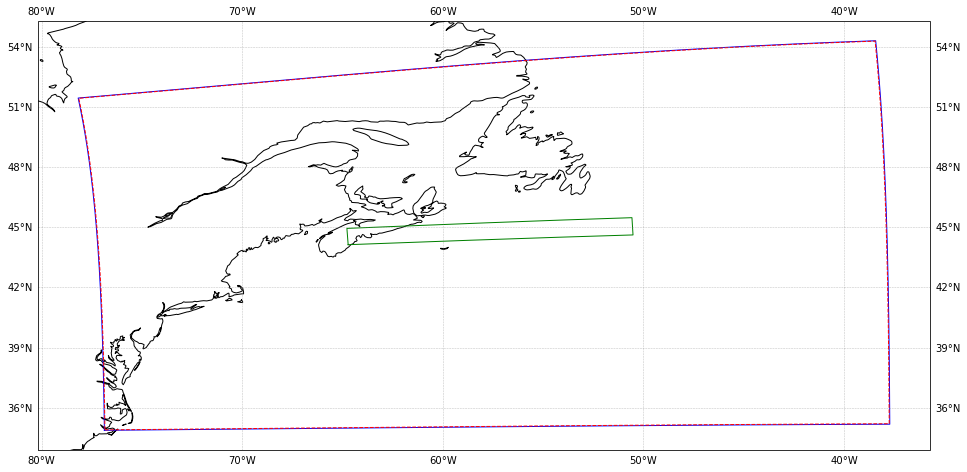

In [10]:
def plot_mesh(lons, lats, savefig=False):
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    
    extremes = None
    for offset, color, lstyle in zip([0, 1, 450], ['blue', 'red', 'green'], ['-', '--', '-']):
        edge_lons = find_edges(lons, offset)
        edge_lats = find_edges(lats, offset)
        plt.plot(edge_lons, edge_lats, color=color, linestyle=lstyle, linewidth=1)
                
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
       
    if savefig:
        plt.savefig(os.path.join(outdir, ('mesh_edges_multiple_offsets.png')))
    else:
        plt.show()
    plt.close('all')

    
with xr.open_dataset(meshfile) as mesh:
    lons = mesh.nav_lon.values
    lats = mesh.nav_lat.values
    plot_mesh(lons, lats)
    

## Plot the points that are in or out of the defined polygon

In [13]:
def plot_points(edge_lons, edge_lats, points, grid=None, savefig=False):

    fig = plt.figure(figsize=(10, 8), dpi=500)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.plot(edge_lons, edge_lats, color='blue', linestyle='-', linewidth=1)
    
    # plot each point. Change the color depending on if the point is inside 
    # or outside the polygon.
    for ind in range(0, len(points)):
        color = 'green'
        if grid is not None:
            color = ['green' if grid[ind] else 'red'][0]
        plt.plot(points[ind][0], points[ind][1], 'o', color=color, markersize=2)
        
    plt.plot(points[0][0], points[0][1], 'o', color='orange', zorder=100)
    plt.plot(points[-1][0], points[-1][1], 'o', color='purple', zorder=100)
    
    if savefig:
        plt.savefig(os.path.join(outdir, ('points.png')))
    else:
        plt.show()
    plt.close('all')


it took 0.35 seconds to find a list of points that are inside the mesh boundary

Plotting all points



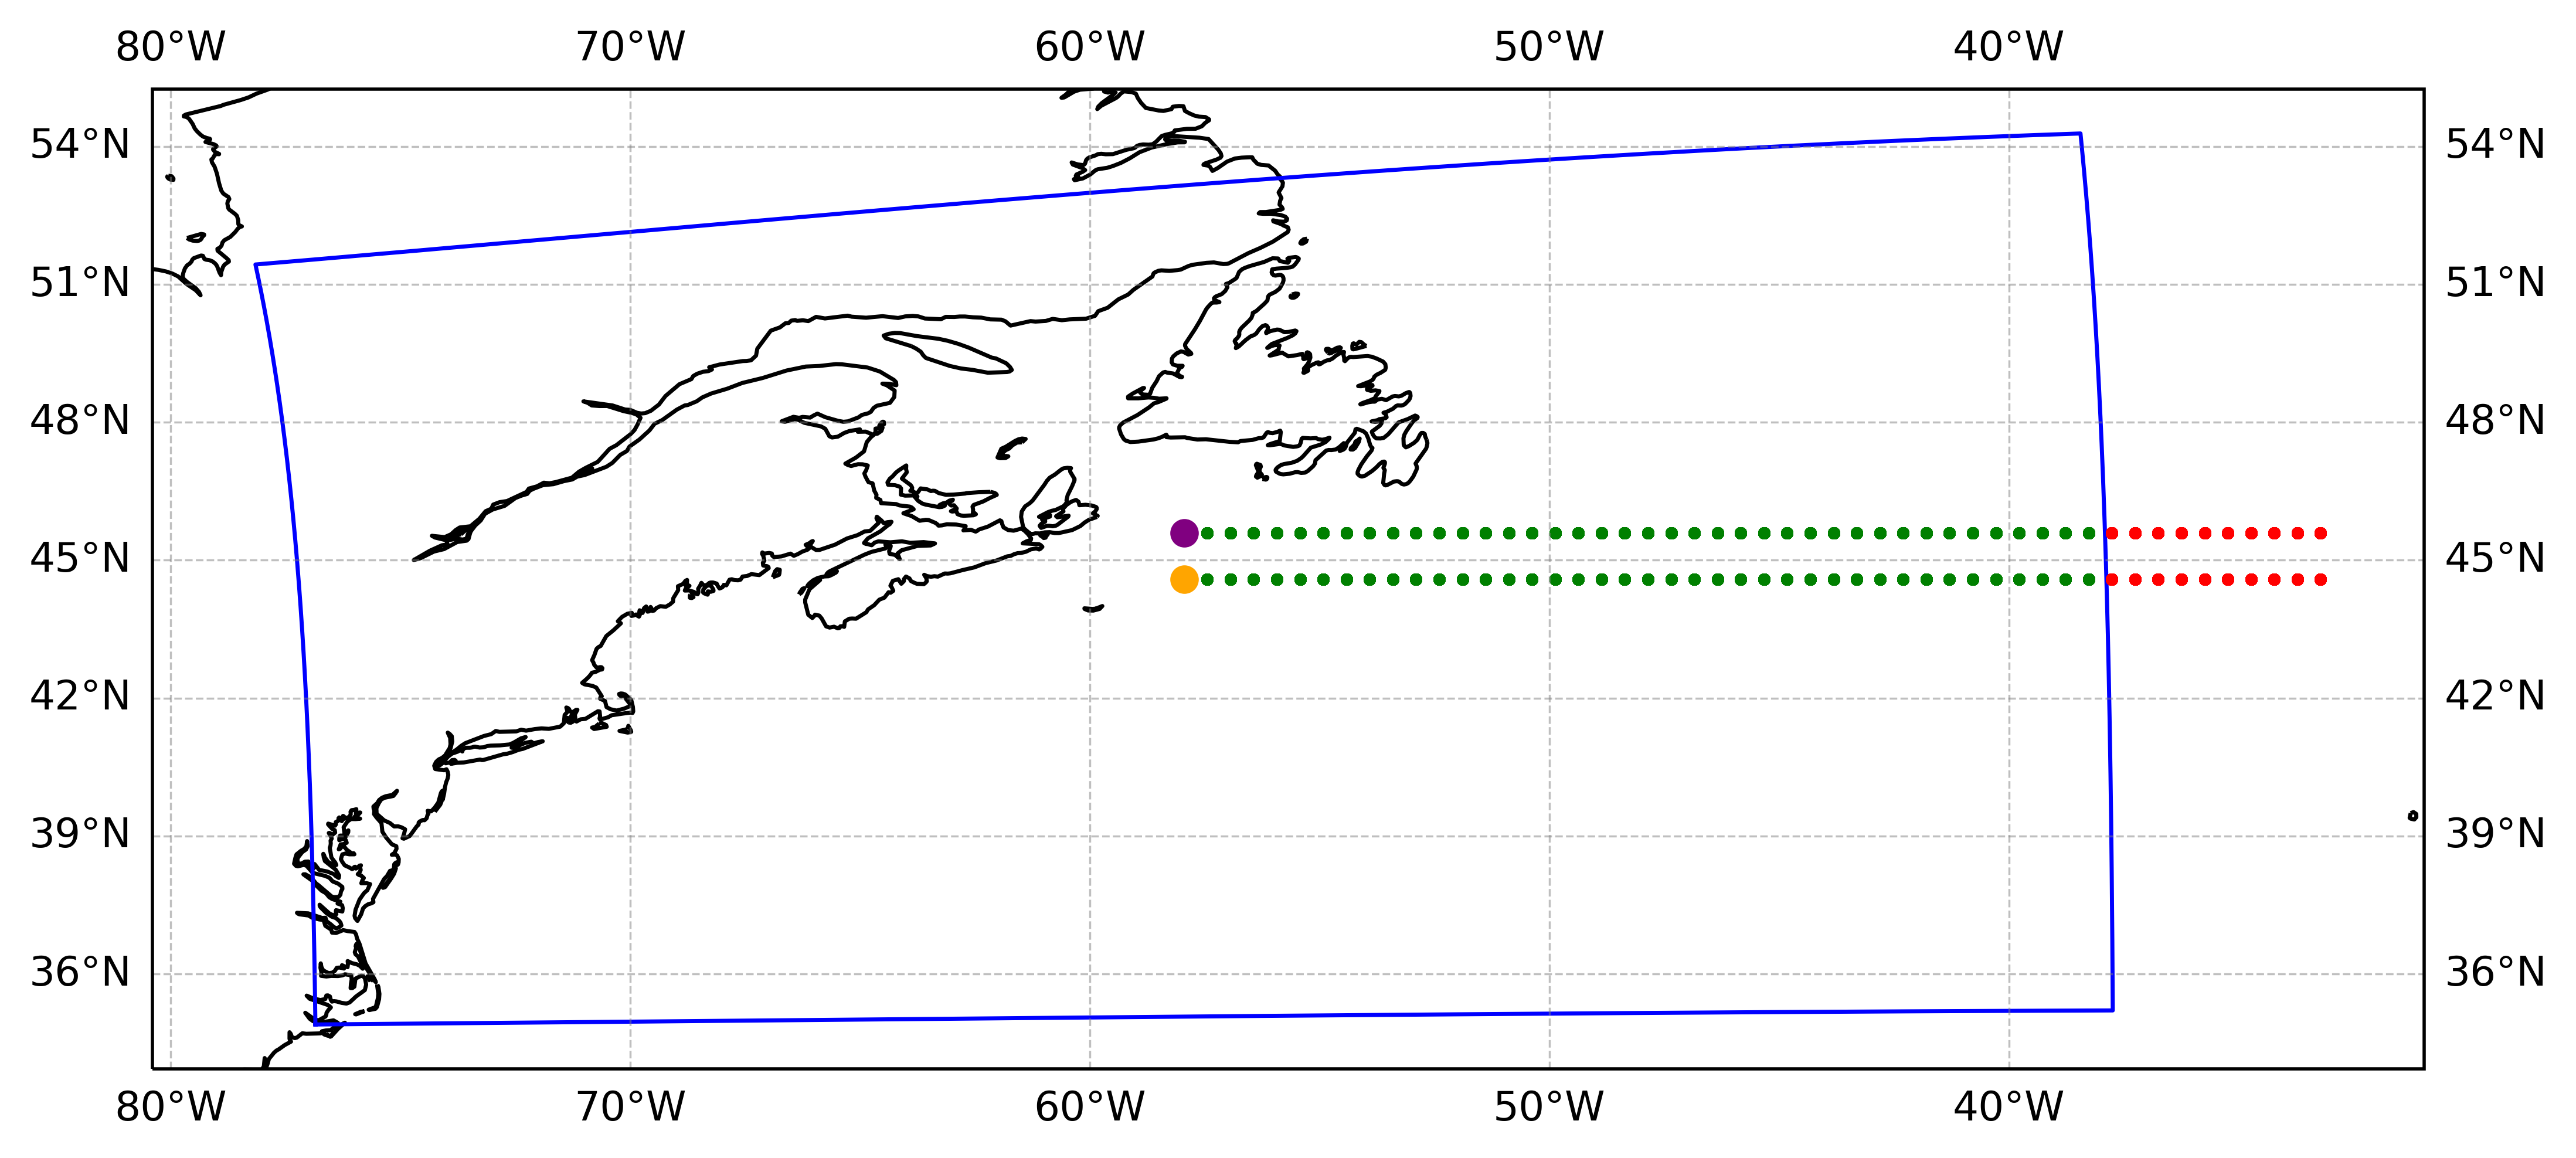



Plotting only the points inside the polygon



In [ ]:
# open the dataset for the mesh file   
with xr.open_dataset(meshfile) as mesh:
    # the lats and lons in the mesh file
    lons = mesh.nav_lon.values
    lats = mesh.nav_lat.values

t1 = datetime.datetime.now()
    
# get the points for the polygon depending on the desired offset
edge_lons = find_edges(lons, 1)
edge_lats = find_edges(lats, 1)

# get the data points (can use line, opendrift, ariane, or other)
points = get_sample_points(ptype='line', lons=lons, lats=lats, numsteps=50)

# Create a polygon boundary and check if the points are inside
coords = [(edge_lons[p], edge_lats[p]) for p in range(0, len(edge_lons)-1)]
p = Path(coords)
grid = p.contains_points(points)

in_points = [(points[ind][0], points[ind][1]) if grid[ind] 
             else (np.nan, np.nan) for ind in range(0, len(points))]

nan_bools = [True if np.isnan(in_points[ind][0]) or np.isnan(in_points[ind][1]) 
             else False for ind in range(0, len(in_points))]

nan_inds = [i for i, x in enumerate(nan_bools) if x]

# only need to add nans if some points leave the domain.
# Otherwise all points are already covered by in_points
finalized_points = in_points
if len(nan_inds) > 0:
    finalized_points = [in_points[ind] if ind < nan_inds[0] 
                        else (np.nan, np.nan) 
                        for ind in range(0, len(in_points))]
    
timediff = "{:.2f}".format((datetime.datetime.now() - t1).total_seconds())
print('\nit took ' + str(timediff) + ' seconds to find a '
      + 'list of points that are inside the mesh boundary')    

create_plot = True
if create_plot:
        
    print('\nPlotting all points\n')
    plot_points(edge_lons, edge_lats, points, grid=grid)

    print('\n\nPlotting only the points inside the polygon\n')
    only_in_points = [(points[ind][0], points[ind][1]) 
                      for ind in range(0, len(points)) if grid[ind]]
    
    plot_points(edge_lons, edge_lats, only_in_points)
    
    print('\n\nPlotting only the points inside the polygon before '
          + 'the points left the domain for the first time\n')
    plot_points(edge_lons, edge_lats, finalized_points)